In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
# import glob
# import anndata as ad
# import collections
# from tqdm import tqdm
import argparse


scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo') 

In [4]:

name = 'test'
meta = 'naive_B/navieB_seurat_meta.csv'
n_jobs = 32
group = 'subtype'

out_pic1 = name + '_Velocity_pic.pdf'
out_pic2 = name + '_Velocity_Paga_pic.pdf'

# os.chdir('/rd2/user/xiacr/sle/')
# results_file = 'output_file/scvelo/' 
adata =sc.read_h5ad('/rd2/user/xiacr/sle/final/scvelo/all_cell_exclude_berry.h5ad')
cell_meta = pd.read_csv(meta)
cell_meta['1'], cell_meta['2'] = cell_meta['Row.names'].str.split('_', 1).str
cell_meta['barcode'] = cell_meta['1']+ '_' + cell_meta['orig.ident']

# check the cell meta 
if not set(['UMAP_1','UMAP_1','barcode']).issubset(cell_meta.columns):
    # print()
    raise RuntimeError('ERROR: seurat cell meta is not valid, please check it!')

In [3]:
cell_meta 

Unnamed: 0              Row.names orig.ident  nCount_RNA  nFeature_RNA  \
0               1   AAACCTGAGAGTGAGA-1_9        MXY        2756          1215   
1               2  AAACCTGAGCTTCGCG-1_14        WYY        5124          1639   
2               3  AAACCTGAGGCCGAAT-1_15         XH        1100           564   
3               4  AAACCTGAGGGCATGT-1_10        QJY        1093           551   
4               5   AAACCTGAGTATCTCG-1_6        LGY        1359           681   
...           ...                    ...        ...         ...           ...   
14990       14991   TTTGTCAGTTGCGTTA-1_5        HXX        4364          1824   
14991       14992   TTTGTCATCACGATGT-1_2        GZR        5939          2136   
14992       14993   TTTGTCATCCAAGCCG-1_7         LL         934           400   
14993       14994  TTTGTCATCGGTCTAA-1_21       ZPP2        3333          1404   
14994       14995  TTTGTCATCTGGTGTA-1_14        WYY        5039          1795   

      group  treatment      pair  percent_mito  percent_ribo  ...  main_type  \
0       SLE  untreated  unpaired      0.000000     28.592163  ...      Bcell   
1       SLE  untreated  unpaired      1.190476     42.681499  ...      Bcell   
2       SLE  untreated   XH_pair      2.454545     36.000000  ...      Bcell   
3        HC         HC  unpaired      3.751144     36.688015  ...      Bcell   
4       SLE  untreated  unpaired      2.060338     35.099338  ...      Bcell   
...     ...        ...       ...           ...           ...  ...        ...   
14990   SLE  untreated  unpaired      0.824931     27.199817  ...      Bcell   
14991   SLE  untreated  unpaired      1.835326     28.136050  ...      Bcell   
14992   SLE  untreated   LL_pair      0.749465     46.466809  ...      Bcell   
14993   SLE    treated  ZPP_pair      2.760276     29.282928  ...      Bcell   
14994   SLE  untreated  unpaired      2.123437     34.292518  ...      Bcell   

       PIC RNA_snn_res.0.6  RNA_snn_res.1.2         subtype    UMAP_1  \
0       no               1                1         B.naive  1.526256   
1       no               1                1         B.naive  0.961507   
2       no               7                5  B.IFN-response  4.471078   
3       no               0                0         B.naive  2.911909   
4       no               0                0         B.naive  3.439248   
...    ...             ...              ...             ...       ...   
14990   no               1                1         B.naive  1.106578   
14991   no               1                1    B.transition  1.870404   
14992   no               1                1         B.naive  0.654200   
14993   no               1                1         B.naive  2.087360   
14994   no               2                3    B.transition  0.882118   

         UMAP_2                   1   2                  barcode  
0     -1.729670  AAACCTGAGAGTGAGA-1   9   AAACCTGAGAGTGAGA-1_MXY  
1     -1.316965  AAACCTGAGCTTCGCG-1  14   AAACCTGAGCTTCGCG-1_WYY  
2      1.679050  AAACCTGAGGCCGAAT-1  15    AAACCTGAGGCCGAAT-1_XH  
3     -2.666804  AAACCTGAGGGCATGT-1  10   AAACCTGAGGGCATGT-1_QJY  
4     -3.528978  AAACCTGAGTATCTCG-1   6   AAACCTGAGTATCTCG-1_LGY  
...         ...                 ...  ..                      ...  
14990 -1.097807  TTTGTCAGTTGCGTTA-1   5   TTTGTCAGTTGCGTTA-1_HXX  
14991  1.180567  TTTGTCATCACGATGT-1   2   TTTGTCATCACGATGT-1_GZR  
14992 -2.675141  TTTGTCATCCAAGCCG-1   7    TTTGTCATCCAAGCCG-1_LL  
14993 -1.119264  TTTGTCATCGGTCTAA-1  21  TTTGTCATCGGTCTAA-1_ZPP2  
14994  1.643623  TTTGTCATCTGGTGTA-1  14   TTTGTCATCTGGTGTA-1_WYY  

[14995 rows x 27 columns]

In [5]:
adata_sub = adata[adata.obs['barcode'].isin(cell_meta['barcode'] )]
adata_sub.obs = adata_sub.obs.rename_axis("CellID").reset_index()
adata_sub.obs = adata_sub.obs.merge(cell_meta, how='left', left_on='barcode', right_on='barcode')
adata_sub.obs = adata_sub.obs.set_index('CellID')

In [22]:
del adata
adata_sub

AnnData object with n_obs × n_vars = 9934 × 2000
    obs: 'Clusters', '_X', '_Y', 'batch', 'barcode', 'Unnamed: 0', 'Row.names', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'group', 'treatment', 'pair', 'percent_mito', 'percent_ribo', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'RNA_snn_res.0.8', 'RNA_snn_res.1', 'seurat_clusters', 'main_type', 'PIC', 'RNA_snn_res.0.6', 'RNA_snn_res.1.2', 'subtype', 'UMAP_1', 'UMAP_2', '1', '2', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma_0', 'velocity_qreg_ratio_0', 'velocity_r2_0', 'velocity_genes_0', 'velocity_gamma_1', 'velocity_qreg_ratio_1', 'velocity_r2_1', 'velocity_genes_1', 'velocity_gamma_2', 'velocity_qreg_ratio_2', 'velocity_r2_2', 'velocity_genes_2', 'velocity_gamma_3',

Skip filtering by dispersion since number of variables are less than `n_top_genes`.
Extracted 2000 highly variable genes.
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 32/40 cores)


  0%|          | 0/9934 [00:00<?, ?cells/s]

    finished (0:00:12) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:02) --> added
    'velocity_harmony', embedded velocity vectors (adata.obsm)
figure cannot be saved as pdf, using png instead.
saving figure to file ./figures/scvelo_test_Velocity_pic.png


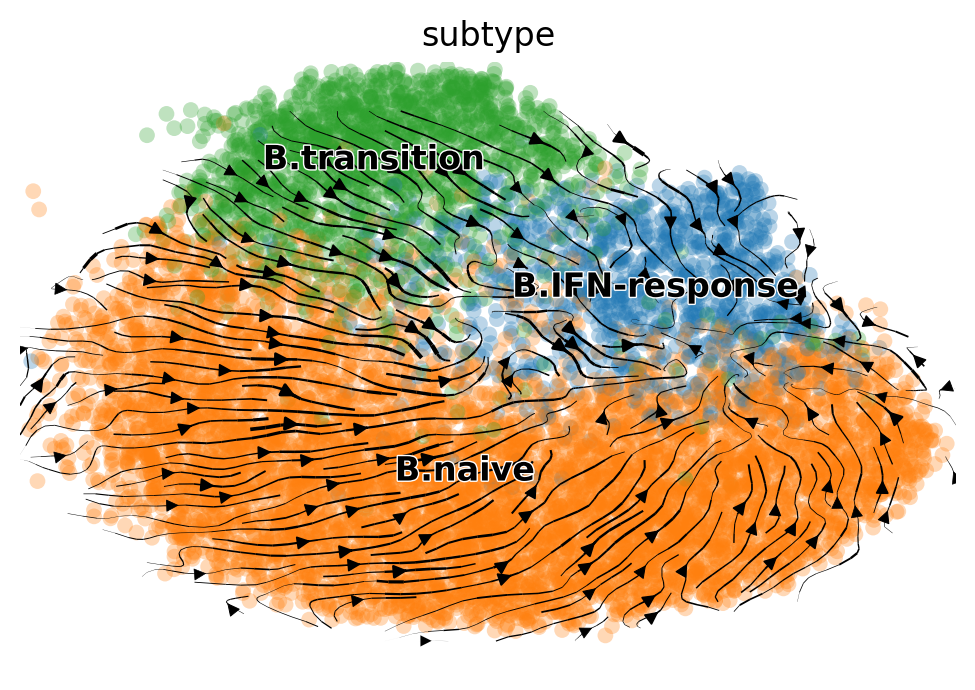

In [16]:
# scv.pp.filter_genes(adata_sub, min_shared_counts=20)
# scv.pp.normalize_per_cell(adata_sub)
# scv.pp.filter_genes_dispersion(adata_sub, n_top_genes=3000)
# scv.pp.log1p(adata_sub)

scv.pp.filter_and_normalize(adata_sub, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata_sub, n_pcs=30, n_neighbors=30)

scv.tl.velocity(adata_sub,groupby='batch')
scv.tl.velocity_graph(adata_sub, n_jobs =n_jobs)

adata_sub.obsm['X_harmony'] =  adata_sub.obs[['UMAP_1','UMAP_2']].to_numpy()
scv.pl.velocity_embedding_stream(adata_sub, basis='harmony',color=group,
                                 save= out_pic1)

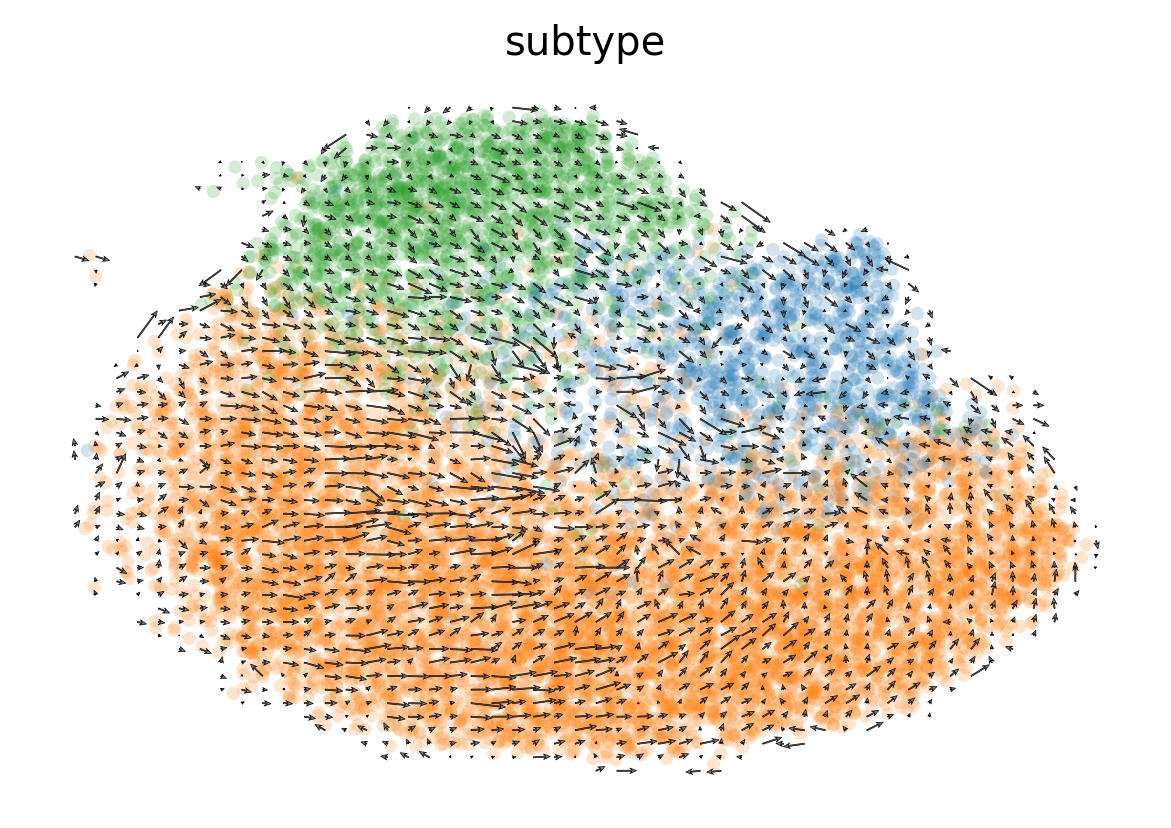

In [57]:
adata_sub.obsm['X_umap'] =  adata_sub.obs[['UMAP_1','UMAP_2']].to_numpy()
scv.pl.velocity_embedding_grid(adata_sub, dpi=120,color=group, basis='umap',scale=0.05, arrow_length =3)

In [11]:
adata_sub.uns['neighbors']['distances'] = adata_sub.obsp['distances']
adata_sub.uns['neighbors']['connectivities'] = adata_sub.obsp['connectivities']

scv.tl.paga(adata_sub, groups=group)

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:03) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


saving figure to file ./figures/scvelo_test_Velocity_Paga_pic.pdf


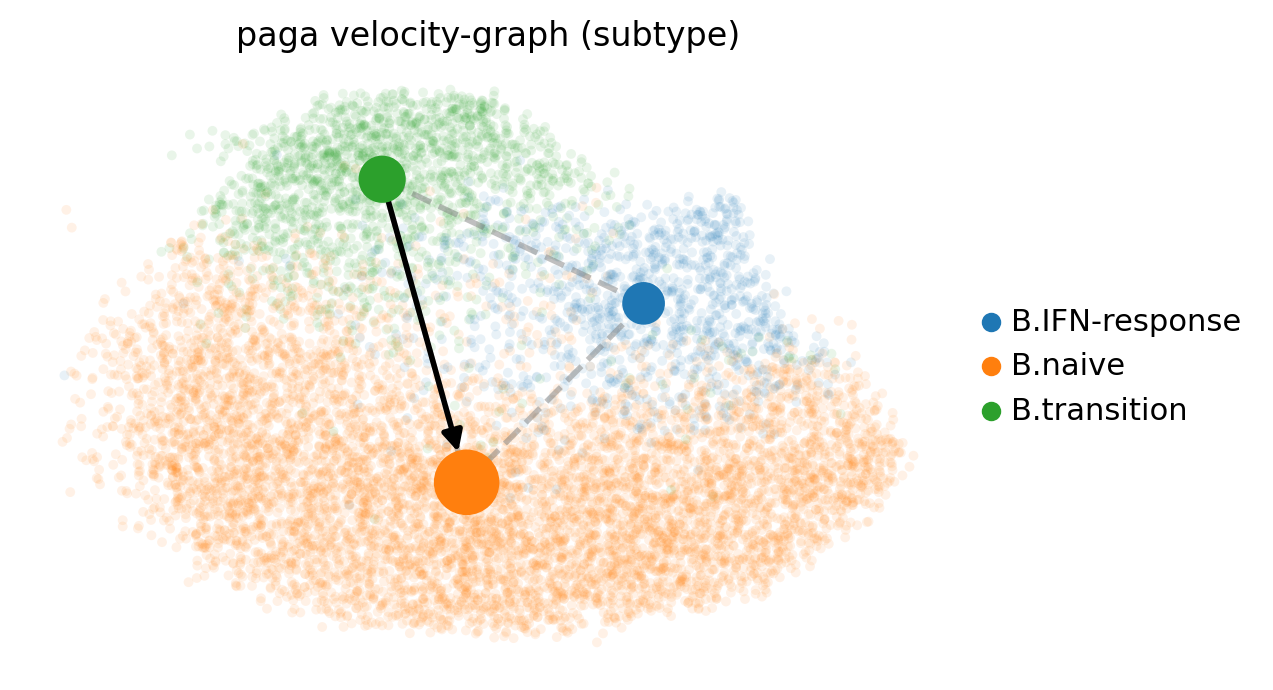

In [10]:
scv.pl.paga(adata_sub, basis='harmony', size=50, alpha=.1,
            min_edge_width=2, node_size_scale=1.5,save=out_pic2)

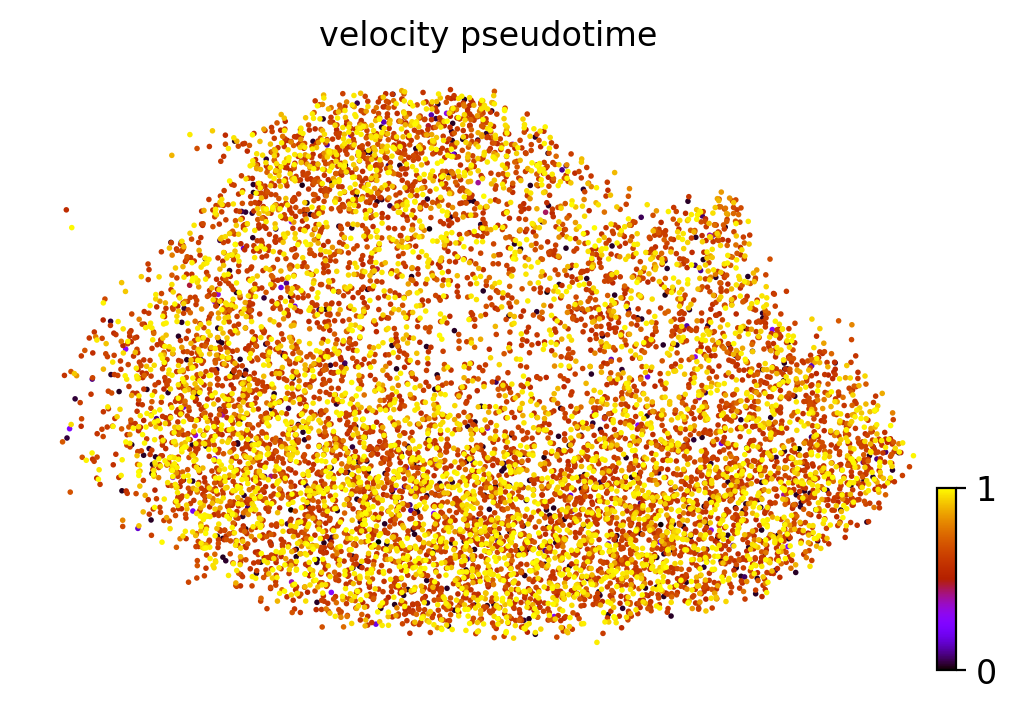

In [35]:
scv.tl.velocity_pseudotime(adata_sub) 
scv.pl.scatter(adata_sub, color='velocity_pseudotime', cmap='gnuplot', basis='harmony')

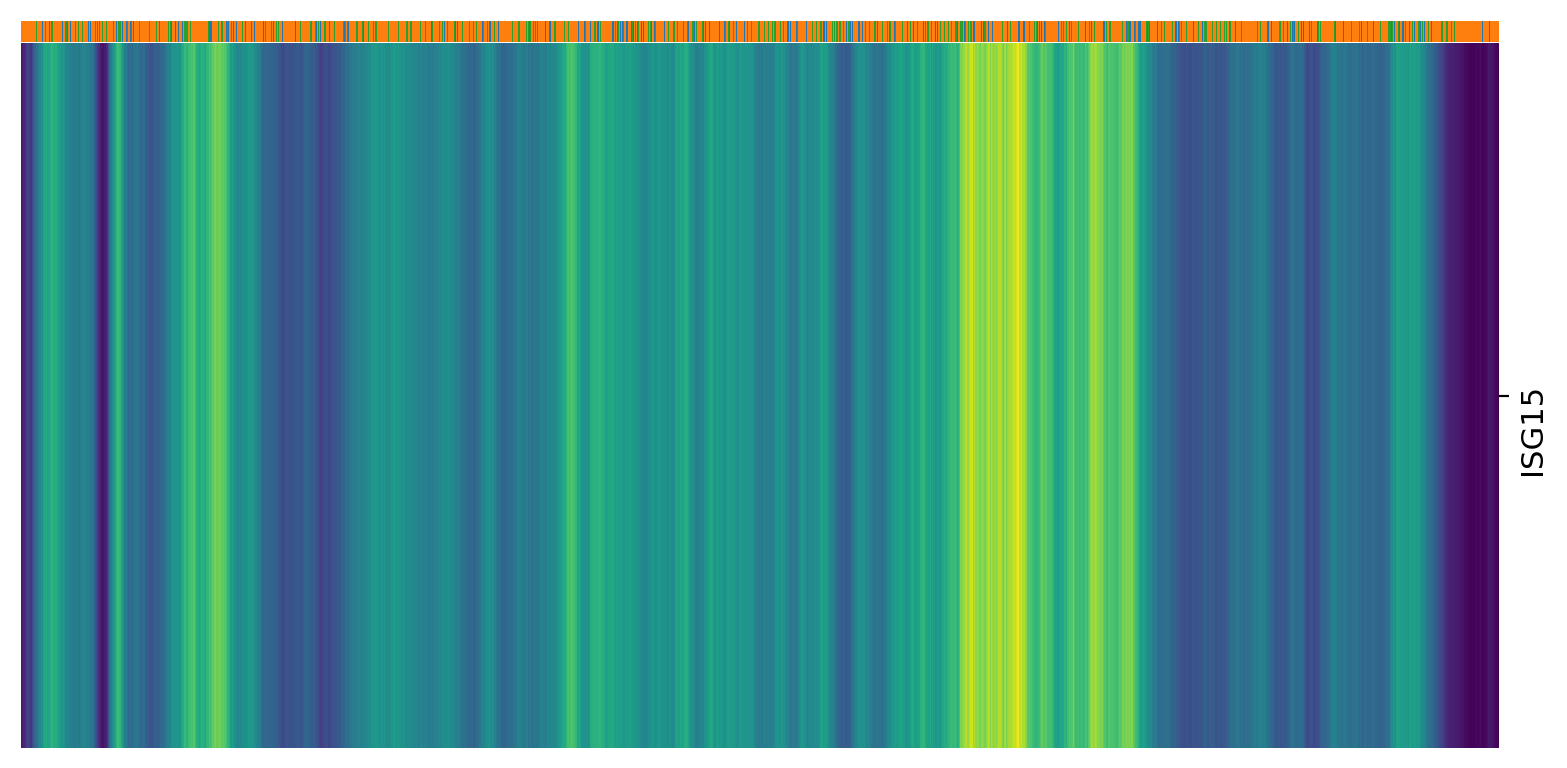

In [40]:
top_genes = ['ISG15','IFI27']
scv.pl.heatmap(adata_sub, var_names=top_genes, sortby='velocity_pseudotime', col_color='subtype', n_convolve=100)

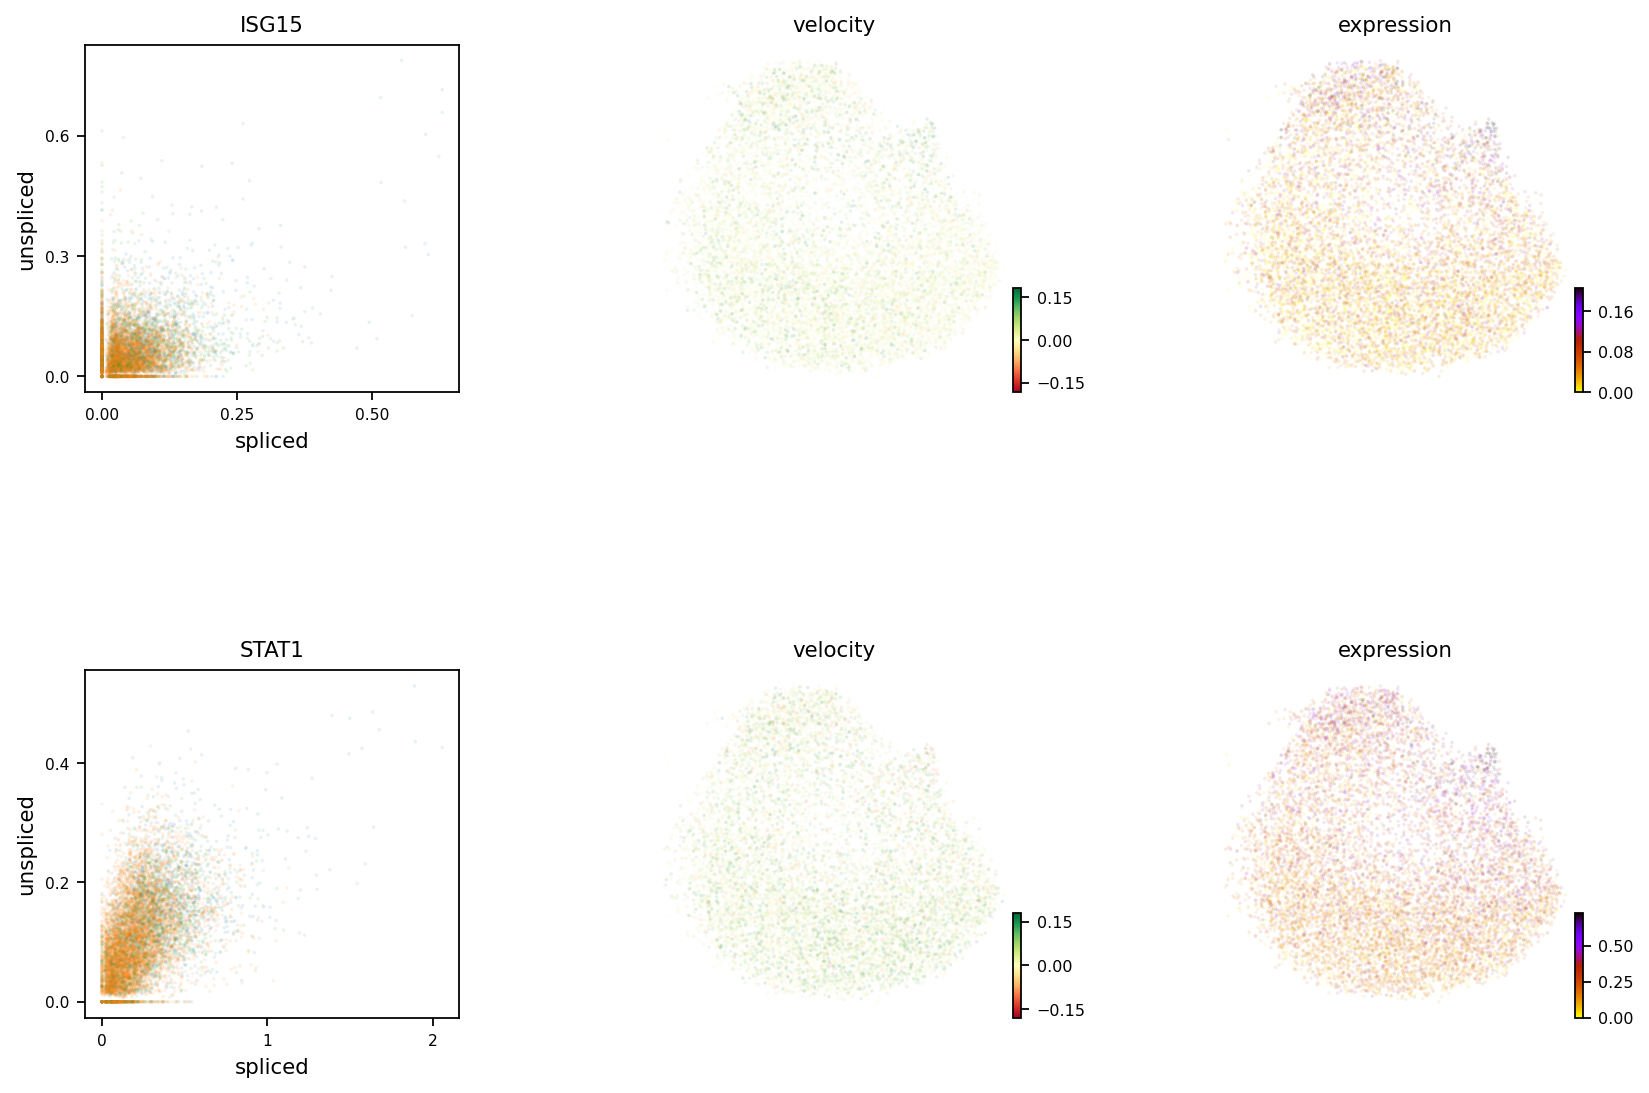

In [52]:
scv.pl.velocity(adata_sub, ['ISG15','STAT1'], ncols=1, basis = 'harmony',color='subtype', dpi=150,alpha = 0.1, figsize=[8,8], size = 10)